Based on https://docs.dgl.ai/en/0.8.x/guide/training-edge.html#:~:text=DGL%20provides%20Graph%20Convolutional%20Matrix,predictor%20module%20is%20called%20BiDecoder%20.

The idea is to train an HGT to learn node representations, and use these node representations to get a link prediction.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installing DGL
! pip install  dgl -f https://data.dgl.ai/wheels/repo.html
! pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn

In [4]:
import pandas as pd
import numpy as np

In [5]:
dgl.seed(42)
torch.manual_seed(42)

In [6]:
from dgl.data.utils import load_graphs
glist, label_dict = load_graphs("./drive/MyDrive/CS6208 Project/Graph Construction/saved_graph.bin")

Adding train and test masks

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response_test.csv')

In [8]:
used_node_idx = 0
node2idx_gene = {}

gene_node_df = pd.read_csv('./drive/MyDrive/CS6208 Project/node_features/gene_node_features.csv')
for gname in set(gene_node_df['genes'].tolist()):
    # print(cl); break
    node2idx_gene[gname] = used_node_idx
    used_node_idx += 1

print("Num of unique genes: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))

Num of unique genes: 27236 | Node indices: 0 to 27235



In [9]:
used_node_idx = 0
node2idx_cellLine = {}

cell_line_nodes_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/node_features/cell_line_node_features.csv')
for cl in set(cell_line_nodes_df['ModelID'].tolist()):
    # print(cl); break
    node2idx_cellLine[cl] = used_node_idx
    used_node_idx += 1

print("Num of unique cell lines: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))

Num of unique cell lines: 1710 | Node indices: 0 to 1709



In [10]:
used_node_idx = 0
node2idx_drug = {}

drug_node_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/node_features/drug_node_features.csv')
for dname in set(drug_node_df['Name'].tolist()):
    # print(cl); break
    node2idx_drug[dname] = used_node_idx
    used_node_idx += 1

print("Num of unique drugs: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))


Num of unique drugs: 1889 | Node indices: 0 to 1888



In [11]:
from tqdm import tqdm

In [12]:
# To obtain a train mask, test mask (complement of train mask), e_type(i.e. edge types for each edge in the graph), ntype
# Reference dataset - https://docs.dgl.ai/en/0.8.x/generated/dgl.data.FB15k237Dataset.html#dgl.data.FB15k237Dataset
# from dgl.data.knowledge_graph import KnowledgeGraphDataset
# class MyDataset(KnowledgeGraphDataset):
#   def __init__(self, raw_dir = "/content/drive/MyDrive/CS6208 Project/"):
#     name = "MyDataset"
#     super().__init__(name)

#   def __getitem__(self, idx):


def get_all_other_edge_features(g):

    # NEW
    # Column Names: ['Unnamed: 0', 'DRUG_NAME', 'AUC', 'DepMap_ID']
    # Triplets (src, dest, feat): get_drug_drug_edges, get_cl_drug_edges, get_gene_gene_edges
    # Pairs (src, dest): get_drug_gene_edges, get_cl_gene_edges
    dir = "/content/drive/MyDrive/CS6208 Project/"
    # s1, d1, edge_feat_drug_drug = get_drug_drug_edges(dir)
    # s2, d2                      = get_drug_gene_edges(dir)
    # s3, d3, edge_feat_cl_drug   = get_cl_drug_edges(dir)
    # s4, d4, edge_feat_gene_gene = get_gene_gene_edges(dir,from_file=False)
    # s5, d5                      = get_cl_gene_edges(dir,from_file=False)

    s1, d1 = g[('drug', 'interacts', 'drug')].edges()
    s2, d2 = g[('drug', 'interacts', 'gene')].edges()
    s3, d3 = g[('cell_line', 'response', 'drug')].edges()
    s4, d4 = g[('gene', 'interacts', 'gene')].edges()
    s5, d5 = g[('cell_line', 'mutates', 'gene')].edges()
    print(s1.shape, s2.shape, s3.shape, s4.shape, s5.shape)
    all_sources = torch.cat([s1, s2, s3, s4, s5])
    all_destinations = torch.cat([d1, d2, d3, d4, d5])
    all_edges = torch.cat([torch.tensor([0]*s1.shape[0]),
                           torch.tensor([1]*s2.shape[0]),
                           torch.tensor([2]*s3.shape[0]),
                          #  glist[0][('cell_line', 'response', 'drug')].edata["he"]. view(-1),
                           torch.tensor([3]*s4.shape[0]),
                           torch.tensor([4]*s5.shape[0])
                           ],)
    all_nodes = torch.cat([torch.tensor([0]*len(node2idx_cellLine)),
                           torch.tensor([1]*len(node2idx_drug)),
                           torch.tensor([2]*len(node2idx_gene)),
                           ],)

    df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response.csv')
    feat_column_list = ['AUC']
    num_feats = len(feat_column_list)

    # print(len(df))
    # # print(df.head(3))
    # sources = []
    # destinations = []
    train_mask = ([1] * s1.shape[0]) + ([1] * s2.shape[0])
    
    # NEW
    # edge_feat_mat = []

    for key, row in tqdm(df.iterrows()):
        # print(key, row) ; break
        cl = row['DepMap_ID']
        drug = row['DRUG_NAME']
        # sources.append(node2idx_cellLine[cl])
        # destinations.append(node2idx_drug[drug])
        # print(sources, destinations)
        # NEW
        # edge_feat = row[feat_column_list].values.astype(np.float64)
        # edge_feat = torch.from_numpy(edge_feat)
        # edge_feat_mat.append(torch.unsqueeze(edge_feat, dim=0)) # Unsqueeze to form row matrix. Concat along axis=0 at the end.
        subset_df_train = train_df[(train_df.DepMap_ID == cl)&(train_df.DRUG_NAME == drug)]
        subset_df_test = test_df[(test_df.DepMap_ID == cl)&(test_df.DRUG_NAME == drug)]
        if len(subset_df_train) != 0:
          train_mask.append(1)
        else:
          train_mask.append(0)
    train_mask += ([1] * s4.shape[0]) + ([1]* s5.shape[0])
    train_mask = torch.tensor(train_mask)
    # sources = torch.tensor(sources)
    # destinations = torch.tensor(destinations)

    # NEW
    # edge_feat_tensor = torch.cat(edge_feat_mat, axis = 0)
    test_mask = 1 - train_mask
    g = dgl.to_homogeneous(g)
    g.edata["e_type"] = all_edges
    g.edata["train_mask"] = train_mask
    g.edata["test_mask"] = test_mask
    g.ndata["ntype"] = all_nodes
    return g

In [13]:
g = get_all_other_edge_features(glist[0])

torch.Size([44104]) torch.Size([11370]) torch.Size([45083]) torch.Size([11937785]) torch.Size([1183425])


45083it [07:35, 98.90it/s] 


In [14]:
g.nodes()

tensor([    0,     1,     2,  ..., 30832, 30833, 30834])

In [15]:
# def get_train_test_edge_masks(g):
#     df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response.csv')
#     feat_column_list = ['AUC']
#     num_feats = len(feat_column_list)

#     train_mask = []

#     for key, row in tqdm(df.iterrows()):
#         cl = row['DepMap_ID']
#         drug = row['DRUG_NAME']
        
#         subset_df_train = train_df[(train_df.DepMap_ID == cl)&(train_df.DRUG_NAME == drug)]
#         subset_df_test = test_df[(test_df.DepMap_ID == cl)&(test_df.DRUG_NAME == drug)]
#         if len(subset_df_train) != 0:
#           train_mask.append(1)
#         else:
#           train_mask.append(0)
#     train_mask = torch.tensor(train_mask)
#     test_mask = 1 - train_mask
#     g.edges[('cell_line', 'response', 'drug')].data["train_mask"] = train_mask
#     g.edges[('cell_line', 'response', 'drug')].data["test_mask"] = test_mask
#     return g

In [16]:
# g = get_train_test_edge_masks(g)

In [17]:
g

Graph(num_nodes=30835, num_edges=13221767,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64), 'ntype': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64), 'e_type': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.int64)})

In [18]:
# # create a new heterograph with reverse edges added in
# # https://discuss.dgl.ai/t/dglheterograph-how-to-add-new-edge-types-especially-reverse-edges/1408/6
# def add_reverse_hetero(g):
#     relations = {}
#     num_nodes_dict = {ntype: g.num_nodes(ntype) for ntype in g.ntypes}
#     for metapath in [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
#                          ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene')]:
#         # Original edges
#         print(metapath)
#         src, dst = g.all_edges(etype=metapath)
#         relations[metapath] = (src, dst)

#         reverse_metapath = (metapath[2], metapath[1] + '_by', metapath[0])
#         relations[reverse_metapath] = (dst, src)           # Reverse edges

#     new_g = dgl.heterograph(relations, num_nodes_dict=num_nodes_dict)

#     # copy_ndata:
#     for ntype in g.ntypes:
#         for k, v in g.nodes[ntype].data.items():
#             new_g.nodes[ntype].data[k] = v.detach().clone()

#     # copy edata
#     # new_g.edges[('cell_line', 'mutates', 'gene')].data["he"] = g.edges[('cell_line', 'mutates', 'gene')].data["he"]
#     for e in [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
#                          ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene')]:
#         print(e)
#         for k, v in g.edges[e].data.items():
#             new_g.edges[e].data[k] = v.detach().clone()
#             new_g.edges[(e[2], e[1]+ "_by", e[0])].data[k] = v.detach().clone()
#         # new_g.edges[eval(f"({e[2]}, {e[1]}+ '_by', {e[0]})")].data["he"] = g.edges(e).data["he"]
#         # new_g.edges[eval(e)].data["he"] = g.edges(e).data["he"]

#     return new_g
# new_g = add_reverse_hetero(g)

In [19]:
# new_g#.edges[('drug', 'response_by', 'cell_line')]

In [20]:
# new_g.edges[('drug', 'response_by', 'cell_line')].data

In [21]:
# new_g.edges[('cell_line', 'response', 'drug')].data

In [22]:
# g.nodes["cell_line"].data["hv"] = g.nodes["cell_line"].data["hv"].to(torch.float32)
# g.nodes["drug"].data["hv"] = g.nodes["drug"].data["hv"].to(torch.float32)
# g.nodes["gene"].data["hv"] = g.nodes["gene"].data["hv"].to(torch.float32)

In [23]:
# new_g.nodes["cell_line"].data["hv"] = new_g.nodes["cell_line"].data["hv"].to(torch.float32)
# new_g.nodes["drug"].data["hv"] = new_g.nodes["drug"].data["hv"].to(torch.float32)
# new_g.nodes["gene"].data["hv"] = new_g.nodes["gene"].data["hv"].to(torch.float32)

In [24]:
# g.nodes["cell_line"].data["hv"].shape, g.nodes["drug"].data["hv"].shape, g.nodes["gene"].data["hv"].shape

In [25]:
g.ndata

{'_ID': tensor([    0,     1,     2,  ..., 27233, 27234, 27235]), '_TYPE': tensor([0, 0, 0,  ..., 2, 2, 2]), 'ntype': tensor([0, 0, 0,  ..., 2, 2, 2])}

In [26]:
g.edata

{'_ID': tensor([       0,        1,        2,  ..., 11937782, 11937783, 11937784]), '_TYPE': tensor([0, 0, 0,  ..., 4, 4, 4]), 'e_type': tensor([0, 0, 0,  ..., 4, 4, 4]), 'train_mask': tensor([1, 1, 1,  ..., 1, 1, 1]), 'test_mask': tensor([0, 0, 0,  ..., 0, 0, 0])}

In [27]:
import dgl.nn as dglnn

In [28]:
# # Reference https://docs.dgl.ai/en/0.8.x/guide/training-node.html
# # Define a Heterograph Conv model

# class RGCN(nn.Module):
#     def __init__(self, in_feats, hid_feats, out_feats, rel_names):
#         super().__init__()
#         # 'mutates', 'response', 'interacts', 'interacts', 'interacts'
#         # self.conv1 = dglnn.HeteroGraphConv({
#         #     rel: dglnn.GraphConv(in_feats, hid_feats)
#         #     for rel in rel_names
#         #     }, aggregate='sum')
#         # self.conv2 = dglnn.HeteroGraphConv({
#         #     rel: dglnn.GraphConv(hid_feats, out_feats)
#         #     for rel in rel_names}, aggregate='sum')
#         self.conv1 = dglnn.HGTConv(in_feats, out_feats, num_heads=1, num_ntypes=3, num_etypes=10)
        

#     def forward(self, graph, inputs):
#         # inputs are features of nodes
#         h = self.conv1(graph, inputs)
#         # print(h)
#         # h = {k: F.relu(v) for k, v in h.items()}
#         # h = self.conv2(graph, h)
#         return h

In [29]:
import dgl.nn as dglnn

In [30]:
class HeteroDotProductPredictor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.W = nn.Linear(in_dim * 2, 1)

    def apply_edges(self, edges):
        # print(edges.src['hv'])
        # print(edges.dst['hv'])
        x = torch.cat([edges.src['hv'], edges.dst['hv']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the RGCN above.
        with graph.local_scope():
            graph.ndata['hv'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(fn.u_dot_v('hv', 'hv', 'score'))
            return graph.edata['score']

In [31]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        # self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.sage = dglnn.HGTConv(in_features, out_features, num_heads=1, num_ntypes=3, num_etypes=10)
        self.pred = HeteroDotProductPredictor(out_features)
        self.cell_line_node_feature_converter = nn.Linear(glist[0].nodes["cell_line"].data["hv"].shape[1], in_features)
        self.gene_node_feature_converter = nn.Linear(glist[0].nodes["gene"].data["hv"].shape[1], in_features)
        self.drug_node_feature_converter = nn.Linear(glist[0].nodes["drug"].data["hv"].shape[1], in_features)

    def forward(self, g, x, etype):
        # Convert all node features to the same size
        cl_node_features = self.cell_line_node_feature_converter(x["cell_line"])
        gene_node_features = self.gene_node_feature_converter(x["gene"])
        drug_node_features = self.drug_node_feature_converter(x["drug"])
        # x = {"cell_line": cl_node_features, "gene": gene_node_features, "drug": drug_node_features}
        x = torch.cat([cl_node_features, drug_node_features, gene_node_features], dim=0)
        h = self.sage(g, x, g.ndata["ntype"], g.edata["e_type"])
        return self.pred(g, h, etype)

In [32]:
# new_g

In [33]:
# new_g.etypes

In [34]:
model = Model(32, 8, 5, [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
                         ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene'), ('drug', 'interacts_by', 'drug'), \
                         ('drug', 'response_by', 'cell_line'), ('gene', 'interacts_by', 'drug'), ('gene', 'interacts_by', 'gene'), \
                         ('gene', 'mutates_by', 'cell_line')])
cl_feats = glist[0].nodes['cell_line'].data['hv'].to(torch.float32)
gene_feats = glist[0].nodes['gene'].data['hv'].to(torch.float32)
drug_feats = glist[0].nodes['drug'].data['hv'].to(torch.float32)
label = glist[0].edges[('cell_line', 'response', 'drug')].data['he']
train_mask = g.edata['train_mask']
node_features = {'cell_line': cl_feats, 'gene': gene_feats, "drug": drug_feats}

In [35]:
train_mask[44104+11370:44104+11370+45083].nonzero().view(-1).shape

torch.Size([34566])

In [36]:
label.shape

torch.Size([45083, 1])

In [38]:
opt = torch.optim.Adam(model.parameters())
# train_idx = g.edata['train_mask'].nonzero().view(-1)
train_idx = train_mask[44104+11370:44104+11370+45083].nonzero().view(-1)
for epoch in range(10):
    # pred = model(g, node_features, ('drug', 'response_by', 'cell_line'))
    pred = model(g, node_features, ('cell_line', 'response', 'drug'))
    print(pred.view(-1)[train_idx].shape)
    print(label.view(-1).shape)
    loss = ((pred.view(-1)[train_idx] - label.view(-1)[train_idx]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


torch.Size([34566])
torch.Size([45083])
0.7781306920177562
torch.Size([34566])
torch.Size([45083])
0.777067615242662
torch.Size([34566])
torch.Size([45083])
0.7759666659577502
torch.Size([34566])
torch.Size([45083])
0.7746822239941512
torch.Size([34566])
torch.Size([45083])
0.7731806241284879
torch.Size([34566])
torch.Size([45083])
0.771420236778635
torch.Size([34566])
torch.Size([45083])
0.7694051826870244
torch.Size([34566])
torch.Size([45083])
0.7670313645283929
torch.Size([34566])
torch.Size([45083])
0.7642450040060685
torch.Size([34566])
torch.Size([45083])
0.7608840642224662


In [39]:
len(pred.view(-1)[train_idx])

34566

In [40]:
g.edata#.data

{'_ID': tensor([       0,        1,        2,  ..., 11937782, 11937783, 11937784]), '_TYPE': tensor([0, 0, 0,  ..., 4, 4, 4]), 'e_type': tensor([0, 0, 0,  ..., 4, 4, 4]), 'train_mask': tensor([1, 1, 1,  ..., 1, 1, 1]), 'test_mask': tensor([0, 0, 0,  ..., 0, 0, 0])}

In [41]:
test_idx = g.edata['test_mask'][44104+11370:44104+11370+45083].nonzero().view(-1)
test_preds = model(g, node_features, ('cell_line', 'response', 'drug')).view(-1)[test_idx]

In [42]:
test_preds

tensor([0.0007, 0.0034, 0.0197,  ..., 0.0040, 0.0406, 0.0018],
       grad_fn=<IndexBackward0>)

In [43]:
nn.MSELoss()(test_preds, label.view(-1)[test_idx])

tensor(0.7648, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [44]:
from scipy.stats import pearsonr, spearmanr
spearmanr(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy())

SignificanceResult(statistic=0.00287926904403549, pvalue=0.767809371673182)

In [45]:
pearsonr(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy())

PearsonRResult(statistic=0.0023998084439212112, pvalue=0.8056224113810161)

In [46]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'actual preds')

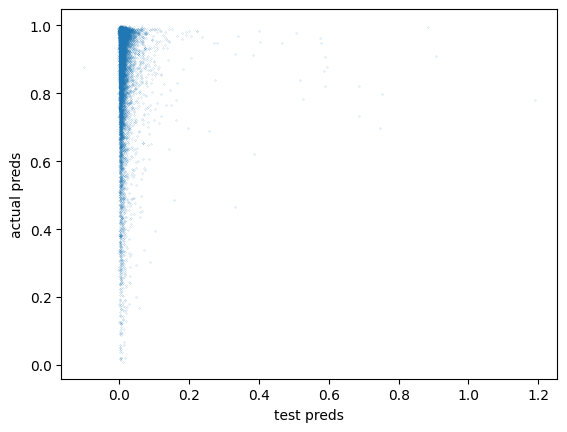

In [47]:
plt.scatter(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy(), s=0.01)
plt.xlabel("test preds")
plt.ylabel("actual preds")